In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import statistics

import sklearn.linear_model
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.preprocessing
import xgboost

import imblearn
import mrmr
import ast
import altair as alt

def handle_scale_and_nan(df):
    features = list(df.select_dtypes(include='float64'))
    cat = list(df.select_dtypes(include='object'))
    scaler = sklearn.preprocessing.StandardScaler().fit(df[features])
    df_cont = pd.DataFrame(data=scaler.transform(df[features]), columns=features)
    df_cat = pd.DataFrame(data=df[cat], columns=cat)
    
    df = pd.concat([df_cat,df_cont],axis=1)
    df = df.fillna(value=0.01)
        
    return df

def split_cats_by_tolerance(
    frame,
    tolerance,
    silent=False,
    randomstate=None,
    split=0.15,
    step=1,
    target="group",
    categories=["Healthy", "AD_MCI", "PD", "PD_MCI_LBD"],
):
    tolerable_list = []
    if randomstate == None:
        randomstate = np.random.randint(0, 2**31)
    elif type(randomstate) == int:
        pass
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(
            frame, test_size=split, random_state=randomstate
        )

        dev_dict = dict(df_dev[target].value_counts())
        test_dict = dict(df_test[target].value_counts())

        tolerable_list = []
        stats_dict = {}
        for i in range(0, len(categories)):
            try:
                percents = [
                    (dev_dict[categories[i]] / len(df_dev)),
                    (test_dict[categories[i]] / len(df_test)),
                ]
            except:
                break
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents], standdev]
            else:
                tolerable_list.append(0)

        randomstate += step

    if sum(tolerable_list) == 4:
        if silent == False:
            print(dev_dict)
            print(test_dict)
            print("Randstate:", randomstate - 1)
            for i in range(0, len(categories)):
                print(
                    "\nPercent",
                    categories[i],
                    "in dev, test:",
                    stats_dict[categories[i]][0],
                    "\nStandard deviation of these values:",
                    stats_dict[categories[i]][1],
                    "\n",
                )
        elif silent == True:
            pass

    return df_dev, df_test

def over_under(df_train,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295)):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """
    # Drop the excessive category and oversample minority to the intermediate category
    df_train_no_excess = df_train[df_train.group != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
    
    return df_train_eq


def mrmr_shorthand(X_train, y_train, X_val, y_val, K, model, score):
    feature_performance = []

    for k in K:
        reduced_features = mrmr.mrmr_classif(X_train, y_train, K=k)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced, y_train)
        feature_performance.append(
            [k, score(y_val, model.predict(X_val_reduced)), reduced_features]
        )
    return feature_performance


def mrmr_feature_selection(
    data_dev,
    split,
    min_features,
    max_features,
    step_features,
    folds,
    ci=0.68,
    balancer="over_under without replacement",
    tolerance=0.01,
    target="group",
    model=sklearn.linear_model.RidgeClassifier(),
    score=sklearn.metrics.balanced_accuracy_score,
    featureselector=mrmr.mrmr_classif,
):

    """
    data_dev: development data in a pandas dataframe
    split: split proportion of training and val data each time a fold is executed
    min_features: minimum number of features to return
    max_features: maximum number of features to return
    step_features: step between evaluation of features
    folds: number of repeat evaluations of one feature space size. The training and validation data will be resampled from the dev data each time. It is important that test data is not fed to this function.
    balancer: (default: over_under without replacement) what data balancer to use on the training data each time the dev data is split.
        supports:
        'over_under without replacement': bp_preprocessing.over_under without performing replacement on the undersampling step
        'over_under with replacement': bp_preprocessing.over_under with performing replacement on the undersampling step
        'over_sampling': imblearn.over_sampling.RandomOverSampler over samples every category except the majority class
        'under_sampling without replacement': imblearn.under_sampling.RandomOverSampler under samples every category except the minority class without performing replacement
        'under_sampling with replacement': imblearn.under_sampling.RandomOverSampler under samples every category except the minority class with performing replacement
    tolerance: (Default=0.01) acceptable level of standard deviation between categories among the training and validation data. Percent categories are calculated first, then their stdev is calculated and compared to the stated tolerance
    target: target column in the dataframe
    model: ML architchture to train to evaluate the best K features via mrmr feature selection
        supports any machine learning model which behaves in the following way:
        model.fit(X_train,y_train)
        sklearn.metrics.<chosen sklearn metric>(y_val,model.predict(X_val))
    score: scoring metric to score the model
        supports sklearn.metrics scoring methods
    featureselector: feature selector algorithm to perform feature selection.
        Currently only supports mrmr


    """
    t0 = time.time()
    ##### Encode the target column #####
    # Creating an instance of label Encoder.
    le = sklearn.preprocessing.LabelEncoder()
    # Create list of encoded labels for dataframe and create "categories" and "cat_in_excess" parameters based on this list. (cat in excess only applies during over_under balancing)
    label = le.fit_transform(data_dev[target])
    categories = np.unique(label)
    cat_in_excess = statistics.mode(label)
    # Add the encoded label column to the dataframe and drop the unencoded label column
    data_dev["encoded_label"] = label
    data_dev = data_dev.drop(columns=target)
    # Create K variable for the list of feature spaces to be tested
    K = list(range(min_features, max_features + 1, step_features))

    ##### Create the balancer parameters #####
    balancer_dict = {
        None: {"method": "NaN", "replacement": "NaN"},
        "over_under with replacement": {"method": "over_under", "replacement": True},
        "over_under without replacement": {
            "method": "over_under",
            "replacement": False,
        },
        "under_sampling with replacement": {"method": "under", "replacement": True},
        "under_sampling without replacement": {"method": "under", "replacement": False},
        "over_sampling": {"method": "over", "replacement": "NaN"},
    }
    balancer_params = balancer_dict.get(balancer)
    replacement = balancer_params["replacement"]
    assert balancer_params != None, "Select a valid balancer option"

    ##### Initiate the results list and begin the folds loop #####
    sum_folded_features = []
    i = 0
    while i < folds:
        # Split dev data
        data_train, data_val = split_cats_by_tolerance(
            data_dev,
            tolerance,
            silent=True,
            split=split,
            target="encoded_label",
            categories=categories,
        )
        X_train = data_train.drop(columns="encoded_label")
        y_train = data_train["encoded_label"]
        X_val = data_val.drop(columns="encoded_label")
        y_val = data_val["encoded_label"]

        # Balance the training data
        if balancer_params["method"] == "NaN":
            pass
        elif balancer_params["method"] == "over_under":
            data_train = over_under(
                data_train,
                cat_in_excess=cat_in_excess,
                target="encoded_label",
                silent=True,
                replacement=replacement,
            )
            X_train = data_train.drop(columns="encoded_label")
            y_train = data_train["encoded_label"]
            X_val = data_val.drop(columns="encoded_label")
            y_val = pd.DataFrame(data_val["encoded_label"], columns=["encoded_label"])
        elif balancer_params["method"] == "under":
            under_sampler = imblearn.under_sampling.RandomUnderSampler(
                replacement=replacement
            )
            X_train, y_train = under_sampler.fit_resample(X_train, y_train)
        elif balancer_params["method"] == "over":
            over_sampler = imblearn.over_sampling.RandomOverSampler()
            X_train, y_train = over_sampler.fit_resample(X_train, y_train)

        # Generate the chosen features from this fold along with the score according to the model selected
        single_fold_features = mrmr_shorthand(
            X_train, y_train, X_val, y_val, K, model, score
        )
        sum_folded_features.append(single_fold_features)
        i += 1

    # Create dataframe from list of features discovered in loop of folds
    sum_folded_features = pd.DataFrame(data=sum_folded_features)

    # Calculate the statistical performance of the features across all the folds
    performance_mean = []
    for j in range(0, len(sum_folded_features.columns)):
        performance_values = []
        for i in range(0, len(sum_folded_features)):
            folded_list = sum_folded_features[j].iloc[i]
            featnum = folded_list[0]
            scores = folded_list[1]
            feats = folded_list[2]
            performance_values.append([featnum, scores, feats])

        # List scores from all folds and take their mean
        scores = []
        for i in range(0, len(performance_values)):
            scores.append(performance_values[i][1])
        mean_score = np.mean(scores)

        # List features from all folds
        features = []
        for i in range(0, len(performance_values)):
            features.append(performance_values[i][2])
        uniquefeatures = list(np.unique(features))

        # Calculate statistical information
        std = np.std(scores)
        onesigma = scipy.stats.norm.interval(0.68, loc=mean_score, scale=std)
        twosigma = scipy.stats.norm.interval(0.95, loc=mean_score, scale=std)
        threesigma = scipy.stats.norm.interval(0.99, loc=mean_score, scale=std)
        yerrone = float(np.diff(onesigma)) / 2
        yerrtwo = float(np.diff(twosigma)) / 2
        yerrthree = float(np.diff(threesigma)) / 2

        performance_mean.append(
            [
                featnum,
                scores,
                mean_score,
                std,
                onesigma,
                twosigma,
                threesigma,
                yerrone,
                yerrtwo,
                yerrthree,
                features,
                uniquefeatures,
            ]
        )
        (
            number,
            scores,
            mean_score,
            std,
            onesigma,
            twosigma,
            threesigma,
            yerrone,
            yerrtwo,
            yerrthree,
            features,
            uniquefeatures,
        ) = zip(*performance_mean)

    performance_mean = pd.DataFrame(
        data=performance_mean,
        columns=[
            "feature_num",
            "ind_scores",
            "avg_score",
            "stdev",
            "onesigma",
            "twosigma",
            "threesigma",
            "yerrone",
            "yerrtwo",
            "yerrthree",
            "features",
            "uniquefeatures",
        ],
    )

    t1 = time.time()
    total_time = t1 - t0
    print("Time elapsed:", total_time)
    return performance_mean


def get_feature_dict(frame, uniqueness):
    """
    Generate a feature dictionary from the performance df output by mrmr_feature_selection
    uniqueness: 'unique' or 'duplicate'. generate dictionary with unique feature names across the folds, or from duplicate feature names across the folds
    """
    count_dict = {}
    for i in range(0, len(frame)):
        # Convert the string into a list of lists
        list_of_lists = frame["features"].iloc[i]
        if type(uniqueness) == int:
            lst, count = np.unique(list_of_lists, return_counts=True)
            lst = lst[count > uniqueness - 1]
        elif uniqueness == "all":
            lst, count = np.unique(list_of_lists, return_counts=True)
            lst = lst[count == len(list_of_lists)]
            # print('features in duplicate list from feature_num',n,':',len(lst))
        else:
            return "Invalid value for parameter 'uniqueness'. Use 'all' or an integer."
        count_dict[frame["feature_num"].iloc[i]] = [len(lst), lst]
    return count_dict


def features_ina_string(frame, uniqueness):
    """
    Reutrn a list of lists for each row of the performance df output by mrmr_feature_selection.
    Assumes features are in 'feautres' column.
    uniqueness: 'unique' or 'duplicate' whether the strings contain the unique or duplicate values from each fold in the features column
    generally only called within altair_feautre_selection_chart visualizer
    """

    def unique_features_to_string(X, uniqueness):
        if type(X) == str:
            string = X
        elif type(X) == list:
            string = str(X)
        # remove the outer quotation marks and brackets
        string = string[2:-2]

        # split the string into a list of lists of values
        lst = [s.strip().split(", ") for s in string.split("], [")]
        lst = np.array(lst).flatten()

        if type(uniqueness) == int:
            lst, count = np.unique(lst, return_counts=True)
            lst = lst[count > uniqueness - 1]
        elif uniqueness == "all":
            lst, count = np.unique(lst, return_counts=True)
            lst = lst[count == len(lst)]
            # print('features in duplicate list from feature_num',n,':',len(lst))
        else:
            raise Exception(
                "Invalid value for parameter 'uniqueness'. Use 'all' or an integer."
            )
        hyphen_items = []
        for i, item in enumerate(lst):
            # if it's an odd index, add a hyphen before the item
            if i != 1 and i % 20 == 1:
                hyphen_items.append("- " + item)
            else:
                hyphen_items.append(item)
        stringy = ", ".join(hyphen_items)
        stringy = stringy.replace("'", "")
        return stringy

    features_string = []
    count_dict = {}
    for i in range(0, len(frame)):
        feature = unique_features_to_string(
            frame["features"].iloc[i], uniqueness=uniqueness
        )
        features_string.append(feature)

    return features_string


def altair_feature_selection_chart(frame, uniqueness, charttitle='plot'):
    """
    Assumes independent scores list is in ind_scores
    Assumes feature number is in feature_num

    """
    df = frame

    # features_ina_string assumes features are in 'features' column
    df["uniqueX_features_ina_string"] = features_ina_string(df,uniqueness=uniqueness)
    # def feature_selection_vis(frame,quantitative,ordinal)
    selection = alt.selection_single(empty="none")

    # Use the explode method to expand the dataframe for the error bars calculation
    df_exploded = df.explode("ind_scores").reset_index(drop=True)
    df_exploded.head(10)
    error_bars = (
        alt.Chart(df_exploded)
        .mark_boxplot()
        .encode(
            y=alt.Y("ind_scores:Q"),
            x=alt.X("feature_num:O"),
        )
        .add_selection(selection)
    )

    points = (
        alt.Chart(df)
        .mark_point(filled=True, size=100,color="black")
        .encode(
            y=alt.Y("avg_score:Q", title="score"),
            x=alt.X("feature_num:O", title="feature_num"),
        )
        .add_selection(selection)
    )

    # Create a list to split into multiple lines in the chart
    df["featuresX"] = (
        df["uniqueX_features_ina_string"].astype(str).str.split("-")
    )  # Create a list to split into multiple lines in the chart
    df["zero"] = 0
    text = (
        alt.Chart(df)
        .mark_text(baseline="bottom", dy=-75)
        .encode(y="zero", text="featuresX")
        .transform_filter(selection)
    )

    chart = (
        (error_bars + points + text)
        .properties(title=charttitle, height=600, width=1000)
        .interactive()
    )

    return chart


In [25]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, auc, roc_curve
from itertools import combinations, cycle
from sklearn.metrics import RocCurveDisplay

list_features = ['AK1C1','TAU', '1433G', 'SCUB1', 'FMOD', 'AMYP', 'CRIS3', 
                'MYDGF', 'RARR2', 'ATS8', 'PGK1', '1433Z', 'SV2A', 'TRH', 'GUAD', 
                'HV69D', 'CO7', 'SERC']

classes_of_interest=['Healthy', 'PD_MCI_LBD', 'PD', 'AD_MCI']


def roc_curves_one_vs_rest(data_dev, data_test):    
    dev = data_dev[list_features]
    dev.insert(0, "group", data_dev['group'], True)
    
    X_test = data_test[list_features]
    y_test = data_test['group']

    X_train = dev.iloc[:,1:] 
    y_train = dev.iloc[:,0] # 0th column is our target


    classifier = sklearn.ensemble.RandomForestClassifier()
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red'])
    for class_id, color in zip(range(4), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {classes_of_interest[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves, using {len(list_features)} features")
    plt.legend()
    plt.savefig('roc_curves.png')
    plt.show()
    

In [3]:
data_full = pd.read_csv('/Users/katherine/Desktop/BrainPower/brainpower/data/split_data/full_data_short.csv')

In [4]:
data_full = data_full.drop(columns='assay_ID')

In [5]:
df = handle_scale_and_nan(data_full)

In [6]:
data_dev, data_test = split_cats_by_tolerance(df,0.01,randomstate=98281)

{'Healthy': 132, 'AD_MCI': 43, 'PD_MCI_LBD': 32, 'PD': 31}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}
Randstate: 98281

Percent Healthy in dev, test: [0.5546218487394958, 0.5714285714285714] 
Standard deviation of these values: 0.008403361344537785 


Percent AD_MCI in dev, test: [0.18067226890756302, 0.19047619047619047] 
Standard deviation of these values: 0.004901960784313722 


Percent PD in dev, test: [0.13025210084033614, 0.11904761904761904] 
Standard deviation of these values: 0.005602240896358551 


Percent PD_MCI_LBD in dev, test: [0.13445378151260504, 0.11904761904761904] 
Standard deviation of these values: 0.007703081232492998 



In [11]:
data_dev

,group,KV37,LV469,LV861,LVX54,LV746,LV218,LV316,LV312,LV310,...,EMIL3,ABCD2,TEN1,PCDAD,ITM2B,ADSV,A0A1W2PRN1,APOF,DCBD2,LMF2
26,AD_MCI,0.002781,0.455179,0.022631,-1.109719,0.234412,-2.744320,-1.717835,-1.923975,-1.572945,...,0.501456,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
127,Healthy,0.931097,0.774007,1.603967,0.841350,1.297017,1.091442,0.757072,1.204679,1.270481,...,-0.043598,0.812885,-1.454916,-0.411891,-0.818386,0.012180,1.440565,-0.566440,-0.597427,0.010000
126,Healthy,0.202452,-0.601165,0.856296,0.510537,0.437282,-0.145638,0.348369,-0.771735,-0.298373,...,0.449742,0.976472,0.705516,0.719542,1.255401,0.025161,-0.101781,0.016711,0.691159,0.010000
32,AD_MCI,-0.538893,0.225321,1.411704,0.727053,0.416150,-0.263679,-1.300613,-1.194371,-1.320269,...,0.895608,0.190128,0.262258,0.505034,1.339508,-1.108741,-0.560544,0.909828,-0.624709,0.010000
95,Healthy,0.587473,0.774040,-0.827039,-0.058034,0.820755,0.383444,0.603097,-0.033550,0.249614,...,1.201187,0.010000,0.701856,-1.037867,1.112116,0.010000,0.010000,-1.046632,-1.747115,-1.234276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Healthy,0.447179,-0.519342,0.304190,0.347386,-0.160000,-0.425210,-0.861640,-0.758026,-1.395646,...,-0.371009,0.010000,0.010000,0.010000,0.157929,0.010000,0.010000,0.010000,0.010000,0.010000
58,Healthy,1.574755,1.500498,-3.054813,0.223791,1.108299,1.925763,1.494669,1.310320,1.018158,...,1.738951,0.627136,-0.371619,0.010000,-1.546448,-0.039164,1.305807,0.010000,0.010000,0.010000
190,Healthy,-2.013146,0.579977,1.270698,1.087660,1.253463,1.790518,-0.187255,0.197752,-0.270647,...,-0.450941,0.010000,0.010000,0.010000,0.159104,0.010000,0.010000,0.010000,0.010000,0.010000
177,Healthy,1.152838,1.323777,1.295623,0.738151,1.342631,0.999611,0.305575,-0.456014,-1.125051,...,-0.532742,0.010000,0.010000,-0.736487,-0.564353,1.193610,0.010000,1.488666,0.010000,1.056909


In [12]:
data_test

,group,KV37,LV469,LV861,LVX54,LV746,LV218,LV316,LV312,LV310,...,EMIL3,ABCD2,TEN1,PCDAD,ITM2B,ADSV,A0A1W2PRN1,APOF,DCBD2,LMF2
30,AD_MCI,0.747051,3.602059,0.522973,-0.347077,0.285105,0.574999,-0.062005,0.959677,-0.435587,...,-0.175265,-0.086903,0.194267,0.336149,0.010000,-0.524263,0.368591,0.010000,0.010000,0.010000
124,Healthy,0.802424,-0.576372,-1.134851,0.175361,0.910190,0.668650,-0.478690,1.092516,-0.637239,...,-1.100661,0.010000,0.010000,0.664790,-0.857378,-1.955225,0.010000,-0.294359,0.010000,0.010000
78,Healthy,-0.527012,-0.380103,0.356486,-1.092255,-0.237790,0.005146,-0.798400,-1.037907,-1.057250,...,0.587121,0.010000,0.010000,0.010000,0.709587,0.010000,-0.913231,0.010000,0.409722,0.700516
172,Healthy,0.129880,0.491930,0.222429,0.979697,0.275436,0.208944,0.531455,0.626515,0.531937,...,-0.371904,0.010000,0.010000,0.010000,0.158078,0.010000,0.010000,0.010000,0.010000,0.010000
68,Healthy,-0.980830,-0.703833,0.632106,-0.691992,-0.444464,-0.175384,-0.701528,-0.404591,-0.515893,...,0.158863,0.010000,0.010000,-0.377941,1.199775,0.957888,0.010000,0.294388,0.010000,-1.299114
166,Healthy,-0.726166,-0.857752,0.121200,0.648194,0.322218,0.179871,-0.078244,-0.222003,0.308197,...,0.824550,-0.171014,1.256175,-0.423821,0.351790,0.226153,0.012853,-0.404841,0.765957,0.010000
152,Healthy,0.867389,0.336420,0.359199,1.588496,0.586617,0.232165,-1.197845,-1.423548,-1.096053,...,-0.069453,0.010000,-0.140617,-0.112548,-0.970288,0.010000,0.010000,-0.425715,0.541971,-0.347741
116,Healthy,0.555865,1.090233,-0.106918,0.980785,0.055309,-4.149164,0.186261,-0.290959,0.481216,...,-0.004344,0.010000,0.010000,0.010000,0.119388,0.010000,0.010000,0.010000,0.010000,0.010000
268,PD_MCI_LBD,2.354348,1.271296,0.525327,0.863480,0.851301,1.545844,1.752722,1.745334,0.639987,...,1.226456,0.010000,-1.164320,-1.426834,-1.223861,0.010000,0.010000,-0.612189,-1.035496,-0.950747
273,PD_MCI_LBD,-0.603312,-1.106082,-0.445711,-0.044471,-1.257652,-1.236378,0.157923,0.198051,0.013730,...,0.221607,0.852515,0.499884,0.010000,-0.462126,-1.172283,0.179222,0.010000,0.010000,0.010000


In [14]:
data_dev = over_under(data_dev,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295))

In [15]:
data_dev

,group,KV37,LV469,LV861,LVX54,LV746,LV218,LV316,LV312,LV310,...,EMIL3,ABCD2,TEN1,PCDAD,ITM2B,ADSV,A0A1W2PRN1,APOF,DCBD2,LMF2
0,AD_MCI,0.002781,0.455179,0.022631,-1.109719,0.234412,-2.744320,-1.717835,-1.923975,-1.572945,...,0.501456,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
1,AD_MCI,-0.538893,0.225321,1.411704,0.727053,0.416150,-0.263679,-1.300613,-1.194371,-1.320269,...,0.895608,0.190128,0.262258,0.505034,1.339508,-1.108741,-0.560544,0.909828,-0.624709,0.010000
2,AD_MCI,0.246663,-0.287996,0.490860,-0.062991,0.872231,1.048033,0.796162,1.879913,1.365369,...,1.290283,0.733818,0.044714,-0.355101,1.199159,-1.825298,1.026749,0.010000,0.010000,0.010000
3,AD_MCI,-0.957252,-1.996674,-0.304400,0.388279,-1.930983,-0.658335,0.352644,0.852217,0.849556,...,-0.659749,0.010000,0.010000,0.214007,0.891278,1.540862,0.010000,0.858155,0.010000,-0.755765
4,AD_MCI,-1.722703,-1.640306,0.476011,-1.854143,-0.533468,0.379645,-0.937557,-1.332032,-0.861370,...,0.046452,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,PD_MCI_LBD,-0.959419,1.263972,-0.089190,-2.415437,-0.558657,0.451383,1.060469,-1.059398,-0.661661,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
168,PD_MCI_LBD,0.632391,-1.044366,0.713339,0.232087,0.325854,0.612230,-1.545069,-3.169413,-0.368058,...,0.809429,-0.518757,-0.128994,-0.480187,-3.453949,-0.570687,-0.169994,0.010000,0.010000,0.010000
169,PD_MCI_LBD,1.704777,0.989289,-0.224353,0.615358,1.749044,0.988775,2.308042,2.732679,2.347374,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
170,PD_MCI_LBD,0.490636,0.404672,0.612595,1.081335,2.226824,0.557728,0.472648,0.099183,0.298615,...,4.010643,0.010000,0.010000,-1.419360,-1.478015,2.021087,0.010000,-1.627466,0.010000,1.069879


In [17]:
data_dev['group'].value_counts()

AD_MCI        43
Healthy       43
PD            43
PD_MCI_LBD    43
Name: group, dtype: int64

In [ ]:
xgboost_performance = mrmr_feature_selection(data_dev,split=0.15,min_features=20,max_features=20,step_features=1,folds=10,ci=0.68,
                                          balancer='over_under without replacement', tolerance=0.01, target='group',
                                          model=xgboost.XGBClassifier(),score=sklearn.metrics.balanced_accuracy_score,featureselector=mrmr.mrmr_classif)

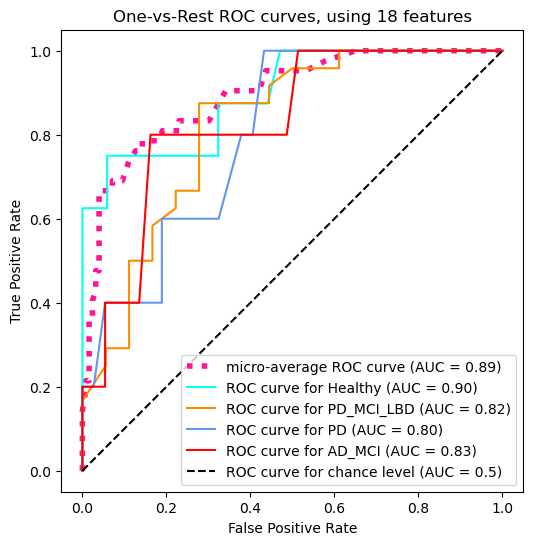

In [26]:
roc_curves_one_vs_rest(data_dev, data_test)